# Uncertainty Quantification in Graph Neural Networks
##### Project hand-in for 02456 Deep Learning @ Technical University of Denmark (Fall 2022)

In this notebook the key ideas behind Deep Evidential Learning will be presented and applied on a regression task using i) a simple 1D toy dataset for analyzing the model behaviour, ii) a synthetically created 3D graph dataset for being able to manipulate with OOD data as well as iii) the molecular 3D graph dataset QM7 for predicting molecular properties using an invariant message-passing network. This 3-step approach was chosen in order to break down the modeling task into simpler ones and for debugging purposes, both assisted in understanding how the models learn uncertainties.

**Authors:**
<br> Albert Kjøller Jacobsen      &nbsp;&emsp; (s194253@student.dtu.dk)
<br> Aron Djurhuus Jacobsen       &nbsp;&nbsp; (s194262@student.dtu.dk)
<br> Felix Borum Burmester        &nbsp;&emsp; (s194266@student.dtu.dk)
<br> Phillip Chavarria Højbjerg   &nbsp; (s184984@student.dtu.dk)

**Supervisor:**
Mikkel Nørgaard Schmidt, DTU Compute


*NOTE:This notebook provides a quick run-down of the handed-in report with a special focus on providing the code associated to the reported results for reproducibility purposes. A detailed analysis of the obtained results is provided in the report.*

### Table of Contents <a class="anchor" id="0"></a>

- [1. Learning with uncertainty - why and how?](#1)
- [2. Towards self-conscious neural networks - Deep Evidential Learning](#2)
    - [2.1 - Modelling higher-order probabilities - the Normal-Inverse-Gamma distribution](#2.1)
- [3. Deep Evidential Regression - evaluating the approach on a toy example](#3)
    - [3.1 - Training the 1D toy model](#3.1)
    - [3.2 - Evaluating the 1D toy model](#3.2)
- [4. Modeling graph-structured data - introducing Message-Passing Neural Networks](#4)
    - [4.1 - Restricting the feature space - invariance matters!](#4.1)
    - [4.2 - Training the synthetic 3D model](#4.2)
    - [4.3 - Evaluating the synthetic 3D model](#4.3)
- [5. Applying uncertainty quantification to a down-stream task - Molecular Property prediction](#5)
    - [5.1 - The QM7 dataset](#5.1)
    - [5.2 - Training the model - predicting molecular energy](#5.2)
    - [5.3 - Evaluating the model](#5.3)
- [6. Discussion and Conclusion](#6)
- [7. Possible Extensions](#7)

### 0. Loading functionalities


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tensorboard import notebook

from content.train import train
from content.evaluate import evaluate_model

### 1. Learning with uncertainty - why and how? <a class="anchor" id="1"></a>

<span style="color:red"> Introducing the (general) problem of interest - why do we need uncertainties?</span>

Machine Learning (ML) models - e.g. Deep Neural Networks - are validly deployed for solving several down-stream tasks due to their data-driven nature which often performs on par with other approaches. Though using such approaches often result in high performing models, these should be deployed with care when the modelled output/decision can have critical costs if modelled improperly - e.g. when classifying patient-related treatment, when estimating depth for visually acting robots or when predicting properties of molecules used within the field of medicine development. As such, capturing uncertainty of a Machine Learning model is crucial for several down-stream tasks and is a hot research topic within the field of Machine Learning.

But what is uncertainty? In fact, the word "uncertainty" does not reduce to a single meaning, but can instead be separated into different types of uncertainty, namely **aleatoric** and **epistemic** uncertainty. While aleatoric uncertainty captures uncertainty within the observed data that a Machine Learning model uses for training, epistemic uncertainty captures uncertainty regarding the model's prediction such that high uncertainty is associated to regions within the data space where the model has limited evidence. These types of uncertainty are visualized in the below figure:

<center>
    <table><tr>
    <td> <img src="figures/aleatoric_simple.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="figures/epistemic_simple.png" alt="Drawing" style="width: 250px;"/> </td>
    </tr></table>
</center>



### 2. Towards self-conscious neural networks - Deep Evidential Learning <a class="anchor" id="2"></a>

<span style="color:red"> How was  and what is Deep Evidential Learning? What have been done in the field and how did models perform when using this approach? </span>

What should be evident, is that aleatoric uncertainty can <span style="color:red"> always </span> be learned directly from data. More difficult is the task of modeling epistemic uncertainty, which one might think of as a kind of "self-conscious" or "self-aware" property of a model - it simply knows what it doesn't know and where it's predictive power is limited! One could argue that such a property should be a key component of all models that are to be deployed for solving a task. But how do we capture such "self-consciousness" when training deep neural networks?

While Bayesian NNs validly provides the tools for obtaining representations of epistemic uncertainty by placing probabilistic priors on the parameters of a network, this model class suffers from several limitations - most <span style="color:red"> prominent </span> is the computational expense originating from e.g. the Monte Carlo sampling <span style="color:red"> which is required as the analytical solution is intractable for deep neural networks. </span>

<span style="color:red"> Evidential learning. Classification. Now regression. </span>

#### 2.1 - Modelling higher-order probabilities - the Normal-Inverse-Gamma distribution <a class="anchor" id="2.1"></a>

In [2]:
from scipy.special import gamma as Gamma
from scipy.stats import expon, gengamma

# Inspiration from here: https://deebuls.github.io/devblog/probability/python/plotting/matplotlib/2020/05/19/probability-normalinversegamma.html
class NIG:
    def __init__(self, gamma, nu, alpha, beta):

        self.gamma, self.nu, self.alpha, self.beta = gamma, nu, alpha, beta
        assert alpha > 0 and beta >= 0 and nu >= 0

    def pdf(self, mu, sigma2):
        t1 = ((self.beta)**self.alpha) * ((self.nu)**0.5)
        t2 = Gamma(self.alpha) * (sigma2 * (2 * np.pi)**0.5)
        t3 = (1 / sigma2**2)**(self.alpha + 1)
        t4 = expon.pdf((2*self.beta + self.nu * (mu - self.gamma)**2)/(2*sigma2**2))
        return (t1/t2)*t3*t4

    def plot(self, zoom=0.9, steps=100, axs=None, colorbar=False):

        max_sig_squared = gengamma.ppf(zoom, self.alpha, self.beta) * self.nu
        mu_range = np.linspace(self.gamma - 1 * max_sig_squared, self.gamma + 1 * max_sig_squared, num=steps)
        sigma_range = np.linspace(0.01, max_sig_squared, num=steps)

        mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)
        pdf_mesh = self.pdf(mu_grid, sigma_grid)

        if axs:
            X, Y, Z = np.sqrt(self.nu / self.beta) * (mu_grid - self.gamma), sigma_grid / self.beta, pdf_mesh
            cplot = axs.contourf(X, Y, Z, 10, cmap='Blues')

            axs.axis('equal')
            axs.set_title(rf"$\gamma$ = {self.gamma}, $\nu$ = {self.nu}, $\alpha$ = {self.alpha}, $\beta$ = {self.beta}")
            axs.set_xlabel(r"$\sqrt{\frac{\nu}{\beta}}(\gamma - \mu)$")
            axs.set_ylabel(r"$\sigma^2 / \beta $")

            if colorbar == True:
                plt.colorbar(cplot)

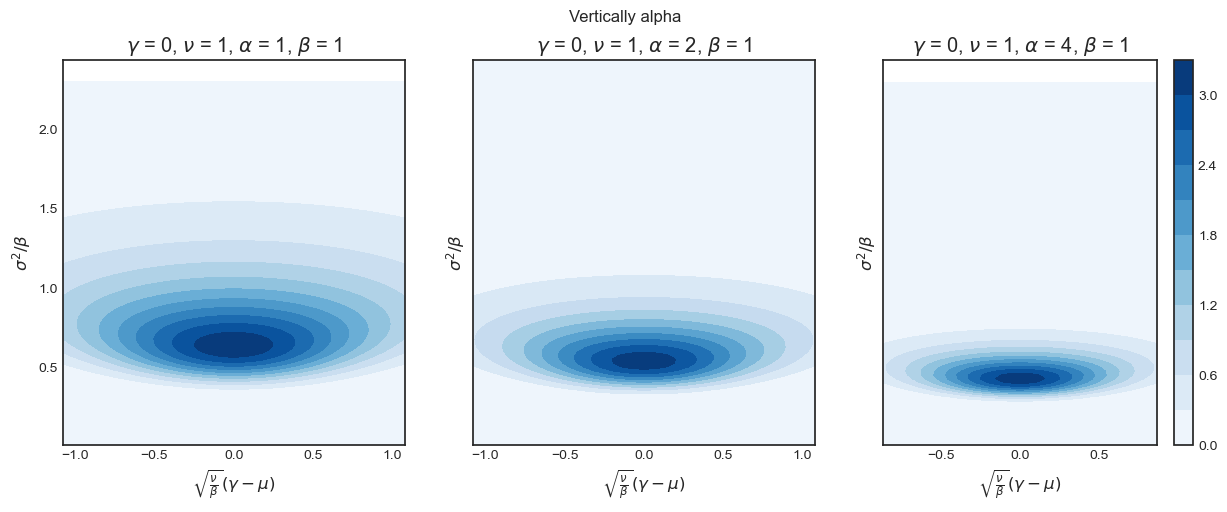

In [4]:
%matplotlib inline
plt.style.use('seaborn-white')

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
fig.suptitle('Vertically alpha')
nig = NIG(gamma=0, nu=1, alpha=1,beta=1)
nig.plot(axs=axs[0])
nig = NIG(gamma=0, nu=1, alpha=2, beta=1)
nig.plot(zoom=0.7, axs=axs[1])
nig = NIG(gamma=0, nu=1, alpha=4, beta=1)
nig.plot(zoom=0.2, axs=axs[2], colorbar=True)

<span style="color:red"> Visualization of the NIG distribution and how it works. </span>.

<span style="color:red"> NIG Loss formulas </span>.

In [ ]:
# NIG Loss (IMPLEMENT ME!)

### 3. Deep Evidential Regression - evaluating the approach on a toy example <a class="anchor" id="3"></a>

Thinking of aleatoric and epistemic uncertainties for multi-dimensional data is abstract and these concepts are often hard to grasp with limited domain-knowledge.

<span style="color:red"> Describe problem setup... </span>

In [ ]:
# load data - from repo (IMPLEMENT ME!)

#### 3.1 - Training the 1D toy model <a class="anchor" id="3.1"></a>

In [ ]:
# code for model implementation (IMPLEMENT ME!)

In [ ]:
# load training loop - from content (IMPLEMENT ME!)

In [ ]:
# CHECK THIS (IMPLEMENT ME!)

%load_ext tensorboard
%tensorboard --logdir logs

#### 3.2 - Evaluating the 1D toy model <a class="anchor" id="3.2"></a>


In [ ]:
# code for evaluation here - produce table and calibration plots (IMPLEMENT ME!)

##### 3.2.1 - Out-of-Distribution performance

In [ ]:
# code for doing a stratified evaluation on OOD data - table and calibration plots (IMPLEMENT ME!)

### 4. Modeling graph-structured data - introducing Message-Passing Neural Networks <a class="anchor" id="4"></a>

<span style="color:red"> Describe problem setup and how data is created </span>


#### 4.1 Restricting the feature space - invariance matters! <a class="anchor" id="4.1"></a>

<span style="color:red"> The concept of invariance! Why does it matter? </span>


#### 4.2 - Training the synthetic 3D model <a class="anchor" id="4.2"></a>

#### 4.3 - Evaluating the synthetic 3D model <a class="anchor" id="4.3"></a>

##### 4.3.1 - Out-of-Distribution performance

### 5. Applying uncertainty quantification to a down-stream task - Molecular Property prediction <a class="anchor" id="5"></a>


#### 5.1 - The QM7 dataset <a class="anchor" id="5.1"></a>

#### 5.2 - Training the model - predicting molecular energy <a class="anchor" id="5.2"></a>


#### 5.3 - Evaluating the model <a class="anchor" id="5.3"></a>

### 6. Discussion and Conclusion <a class="anchor" id="6"></a>